<a href="https://colab.research.google.com/github/SouparnaChatterjee/AUTOMATION/blob/main/depthanalysis%2Bmap%2Blabels.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


0: 384x640 5 persons, 15 cars, 3 trucks, 2 traffic lights, 2857.2ms
Speed: 6.5ms preprocess, 2857.2ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


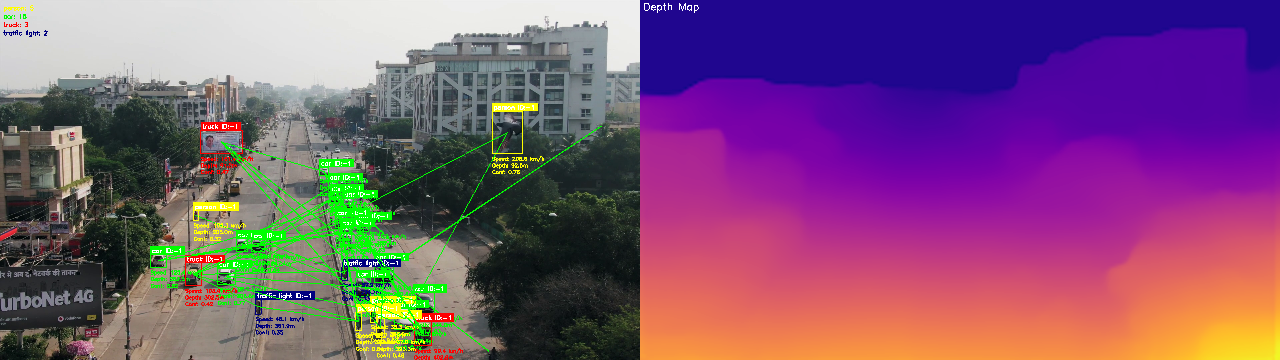


0: 384x640 3 persons, 15 cars, 3 trucks, 1 traffic light, 3910.0ms
Speed: 4.4ms preprocess, 3910.0ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


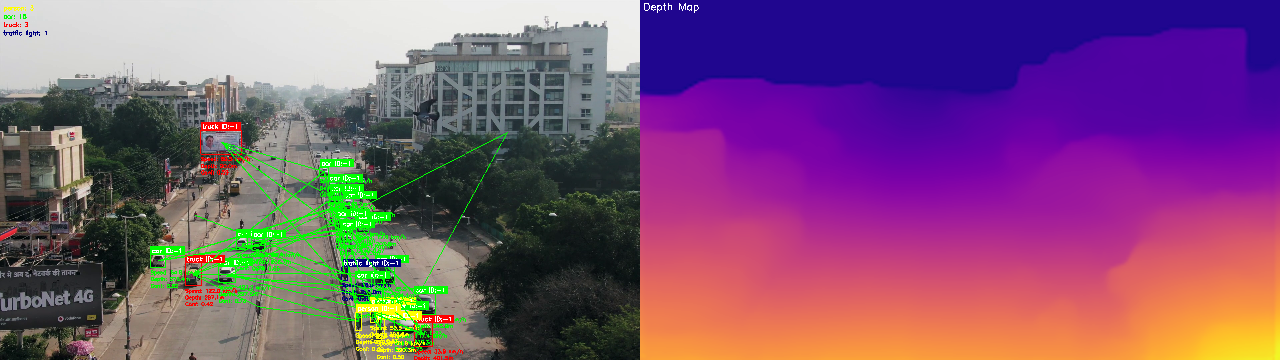


0: 384x640 3 persons, 15 cars, 3 trucks, 1 bird, 2834.7ms
Speed: 4.6ms preprocess, 2834.7ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)
Error during processing: 'unknown'

Processing complete
Outputs saved:
- processed_combined.mp4
- depth_map.mp4
- output_frames/
- depth_maps/


In [3]:
# Initial setup and imports
!pip install torch torchvision ultralytics timm
!pip install -q opencv-python matplotlib gdown

# Install MiDaS properly
!git clone https://github.com/isl-org/MiDaS.git
!pip install -q -r MiDaS/requirements.txt

import torch
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
from ultralytics import YOLO
import time
import os
import sys

# Add MiDaS to Python path
sys.path.append('./MiDaS')

# Download the video using gdown
!gdown --id 12e8OlHSJ4B1PXDSKxUkDA6hHYUpV5UMV -O aerial_traffic.mp4

# COCO class names for traffic analysis
COCO_CLASSES = {
    0: 'person',
    1: 'bicycle',
    2: 'car',
    3: 'motorcycle',
    4: 'airplane',
    5: 'bus',
    6: 'train',
    7: 'truck',
    8: 'boat',
    9: 'traffic light',
    10: 'fire hydrant'
}

# Colors for different classes (BGR format)
COLORS = {
    'person': (0, 255, 255),     # Yellow
    'car': (0, 255, 0),          # Green
    'bus': (255, 0, 0),          # Blue
    'truck': (0, 0, 255),        # Red
    'motorcycle': (255, 255, 0),  # Cyan
    'bicycle': (255, 0, 255),     # Magenta
    'traffic light': (128, 0, 0), # Dark Blue
    'default': (128, 128, 128)    # Gray
}

class AerialTrafficDetector:
    def __init__(self):
        # Initialize YOLO with better model
        self.yolo_model = YOLO('yolov8x.pt')

        try:
            self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
            print(f"Using device: {self.device}")

            # Load MiDaS model
            model_type = "MiDaS_small"
            self.midas = torch.hub.load("intel-isl/MiDaS", model_type)
            self.midas.to(self.device)
            self.midas.eval()

            # Load transforms
            self.midas_transforms = torch.hub.load("intel-isl/MiDaS", "transforms")
            self.transform = self.midas_transforms.small_transform

        except Exception as e:
            print(f"Error initializing MiDaS: {str(e)}")
            raise

        self.previous_positions = {}
        self.track_history = {}
        self.previous_time = time.time()
        self.scale_factor = 0.2
        self.track_length = 30
        self.class_counts = {cls_name: 0 for cls_name in COCO_CLASSES.values()}

    def get_color(self, class_name):
        return COLORS.get(class_name, COLORS['default'])

    def calculate_speed(self, current_pos, previous_pos, time_diff):
        if time_diff <= 0:
            return 0
        pixel_distance = np.sqrt(
            (current_pos[0] - previous_pos[0])**2 +
            (current_pos[1] - previous_pos[1])**2
        )
        meters = pixel_distance * self.scale_factor
        return (meters / time_diff) * 3.6  # Convert to km/h

    def update_trajectory(self, obj_id, center, class_name):
        if obj_id not in self.track_history:
            self.track_history[obj_id] = {'positions': [], 'class': class_name}
        self.track_history[obj_id]['positions'].append(center)
        if len(self.track_history[obj_id]['positions']) > self.track_length:
            self.track_history[obj_id]['positions'].pop(0)

    def draw_trajectory(self, frame, obj_id):
        if obj_id in self.track_history and len(self.track_history[obj_id]['positions']) > 1:
            points = np.array(self.track_history[obj_id]['positions'], dtype=np.int32)
            class_name = self.track_history[obj_id]['class']
            color = self.get_color(class_name)
            cv2.polylines(frame, [points], False, color, 2)

    def process_frame(self, frame):
        current_time = time.time()

        # Reset class counts
        self.class_counts = {cls_name: 0 for cls_name in COCO_CLASSES.values()}

        # YOLO Detection
        results = self.yolo_model(frame, conf=0.3)

        # Depth Estimation
        input_batch = self.transform(frame).to(self.device)
        with torch.no_grad():
            prediction = self.midas(input_batch)
            prediction = torch.nn.functional.interpolate(
                prediction.unsqueeze(1),
                size=frame.shape[:2],
                mode="bicubic",
                align_corners=False,
            ).squeeze()
        depth_map = prediction.cpu().numpy()

        # Normalize depth map for visualization
        depth_map_normalized = cv2.normalize(depth_map, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)
        depth_colormap = cv2.applyColorMap(depth_map_normalized, cv2.COLORMAP_PLASMA)

        # Create annotated frame
        annotated_frame = frame.copy()

        # Create combined visualization
        combined_frame = np.zeros((frame.shape[0], frame.shape[1]*2, 3), dtype=np.uint8)
        combined_frame[:, :frame.shape[1]] = annotated_frame
        combined_frame[:, frame.shape[1]:] = depth_colormap

        # Add depth map title
        cv2.putText(combined_frame,
                   'Depth Map',
                   (frame.shape[1] + 10, 30),
                   cv2.FONT_HERSHEY_SIMPLEX,
                   1.0, (255, 255, 255), 2)

        # Process detections
        for r in results:
            boxes = r.boxes
            for box in boxes:
                x1, y1, x2, y2 = box.xyxy[0].cpu().numpy()
                center = (int((x1 + x2) / 2), int((y1 + y2) / 2))

                obj_id = int(box.id) if box.id is not None else -1
                conf = float(box.conf)
                cls_id = int(box.cls)
                class_name = COCO_CLASSES.get(cls_id, 'unknown')

                # Update class counts
                self.class_counts[class_name] += 1

                # Get color for this class
                color = self.get_color(class_name)

                # Calculate speed
                speed = 0
                if obj_id in self.previous_positions:
                    prev_pos = self.previous_positions[obj_id]
                    time_diff = current_time - self.previous_time
                    speed = self.calculate_speed(center, prev_pos, time_diff)

                # Update tracking
                self.previous_positions[obj_id] = center
                self.update_trajectory(obj_id, center, class_name)
                self.draw_trajectory(combined_frame, obj_id)

                # Get depth for object
                obj_depth = np.mean(depth_map[int(y1):int(y2), int(x1):int(x2)])

                # Draw bounding box and label
                cv2.rectangle(combined_frame,
                            (int(x1), int(y1)),
                            (int(x2), int(y2)),
                            color, 2)

                # Create label background
                label = f'{class_name} ID:{obj_id}'
                (label_w, label_h), _ = cv2.getTextSize(label,
                                                       cv2.FONT_HERSHEY_SIMPLEX,
                                                       0.6, 2)
                cv2.rectangle(combined_frame,
                            (int(x1), int(y1) - label_h - 10),
                            (int(x1) + label_w + 10, int(y1)),
                            color, -1)

                # Add label text
                cv2.putText(combined_frame,
                           label,
                           (int(x1) + 5, int(y1) - 5),
                           cv2.FONT_HERSHEY_SIMPLEX,
                           0.6, (255, 255, 255), 2)

                # Add additional information
                info_text = [
                    f'Speed: {speed:.1f} km/h',
                    f'Depth: {obj_depth:.1f}m',
                    f'Conf: {conf:.2f}'
                ]

                for i, text in enumerate(info_text):
                    cv2.putText(combined_frame,
                              text,
                              (int(x1), int(y2) + 20 + (i * 20)),
                              cv2.FONT_HERSHEY_SIMPLEX,
                              0.5, color, 2)

        # Add class counts
        y_offset = 30
        x_offset = 10
        for cls_name, count in self.class_counts.items():
            if count > 0:
                color = self.get_color(cls_name)
                label = f'{cls_name}: {count}'
                cv2.putText(combined_frame,
                           label,
                           (x_offset, y_offset),
                           cv2.FONT_HERSHEY_SIMPLEX,
                           0.6, color, 2)
                y_offset += 25

                if y_offset > 150:
                    y_offset = 30
                    x_offset += 200

        self.previous_time = current_time
        return combined_frame, depth_colormap

def save_frame(frame, frame_count, prefix="frame"):
    """Save individual frames for analysis"""
    if frame_count % 30 == 0:  # Save every 30th frame
        filename = f"{prefix}_{frame_count}.jpg"
        cv2.imwrite(filename, frame)
        print(f"Saved {filename}")

def process_video(video_path):
    try:
        detector = AerialTrafficDetector()
    except Exception as e:
        print(f"Error creating detector: {str(e)}")
        return

    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"Error: Could not open video file: {video_path}")
        return

    # Get video properties
    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    print(f"Video properties: {frame_width}x{frame_height} @ {fps}fps")

    # Create output directories
    os.makedirs('output_frames', exist_ok=True)
    os.makedirs('depth_maps', exist_ok=True)

    # Create video writers
    out_combined = cv2.VideoWriter('processed_combined.mp4',
                                 cv2.VideoWriter_fourcc(*'mp4v'),
                                 fps,
                                 (frame_width * 2, frame_height))

    out_depth = cv2.VideoWriter('depth_map.mp4',
                               cv2.VideoWriter_fourcc(*'mp4v'),
                               fps,
                               (frame_width, frame_height))

    frame_count = 0
    processing_interval = 2  # Process every 2nd frame

    try:
        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break

            frame_count += 1
            if frame_count % processing_interval != 0:
                continue

            # Process frame
            combined_frame, depth_colormap = detector.process_frame(frame)

            # Write frames
            out_combined.write(combined_frame)
            out_depth.write(depth_colormap)

            # Save periodic frames
            if frame_count % 30 == 0:
                save_frame(combined_frame, frame_count, "output_frames/combined")
                save_frame(depth_colormap, frame_count, "depth_maps/depth")

            # Display progress
            if frame_count % 30 == 0:
                progress = (frame_count / total_frames) * 100
                print(f"Processing: {progress:.1f}% complete")

            # Display frame
            display_frame = cv2.resize(combined_frame, (1280, 360))
            cv2_imshow(display_frame)

            if frame_count % 10 == 0:
                from IPython.display import clear_output
                clear_output(wait=True)

            if cv2.waitKey(1) & 0xFF == ord('q'):
                break

    except Exception as e:
        print(f"Error during processing: {str(e)}")

    finally:
        cap.release()
        out_combined.release()
        out_depth.release()
        cv2.destroyAllWindows()
        print("\nProcessing complete")
        print("Outputs saved:")
        print("- processed_combined.mp4")
        print("- depth_map.mp4")
        print("- output_frames/")
        print("- depth_maps/")

# Main execution
if __name__ == "__main__":
    video_path = 'aerial_traffic.mp4'

    # Verify video exists
    if not os.path.exists(video_path):
        print(f"Error: Video file not found at {video_path}")
        exit()

    # Check GPU availability
    print("GPU Available:", torch.cuda.is_available())
    if torch.cuda.is_available():
        print("GPU Device:", torch.cuda.get_device_name(0))

    print(f"\nStarting video processing: {video_path}")
    try:
        process_video(video_path)
    except Exception as e:
        print(f"Error during video processing: {str(e)}")

Processing complete


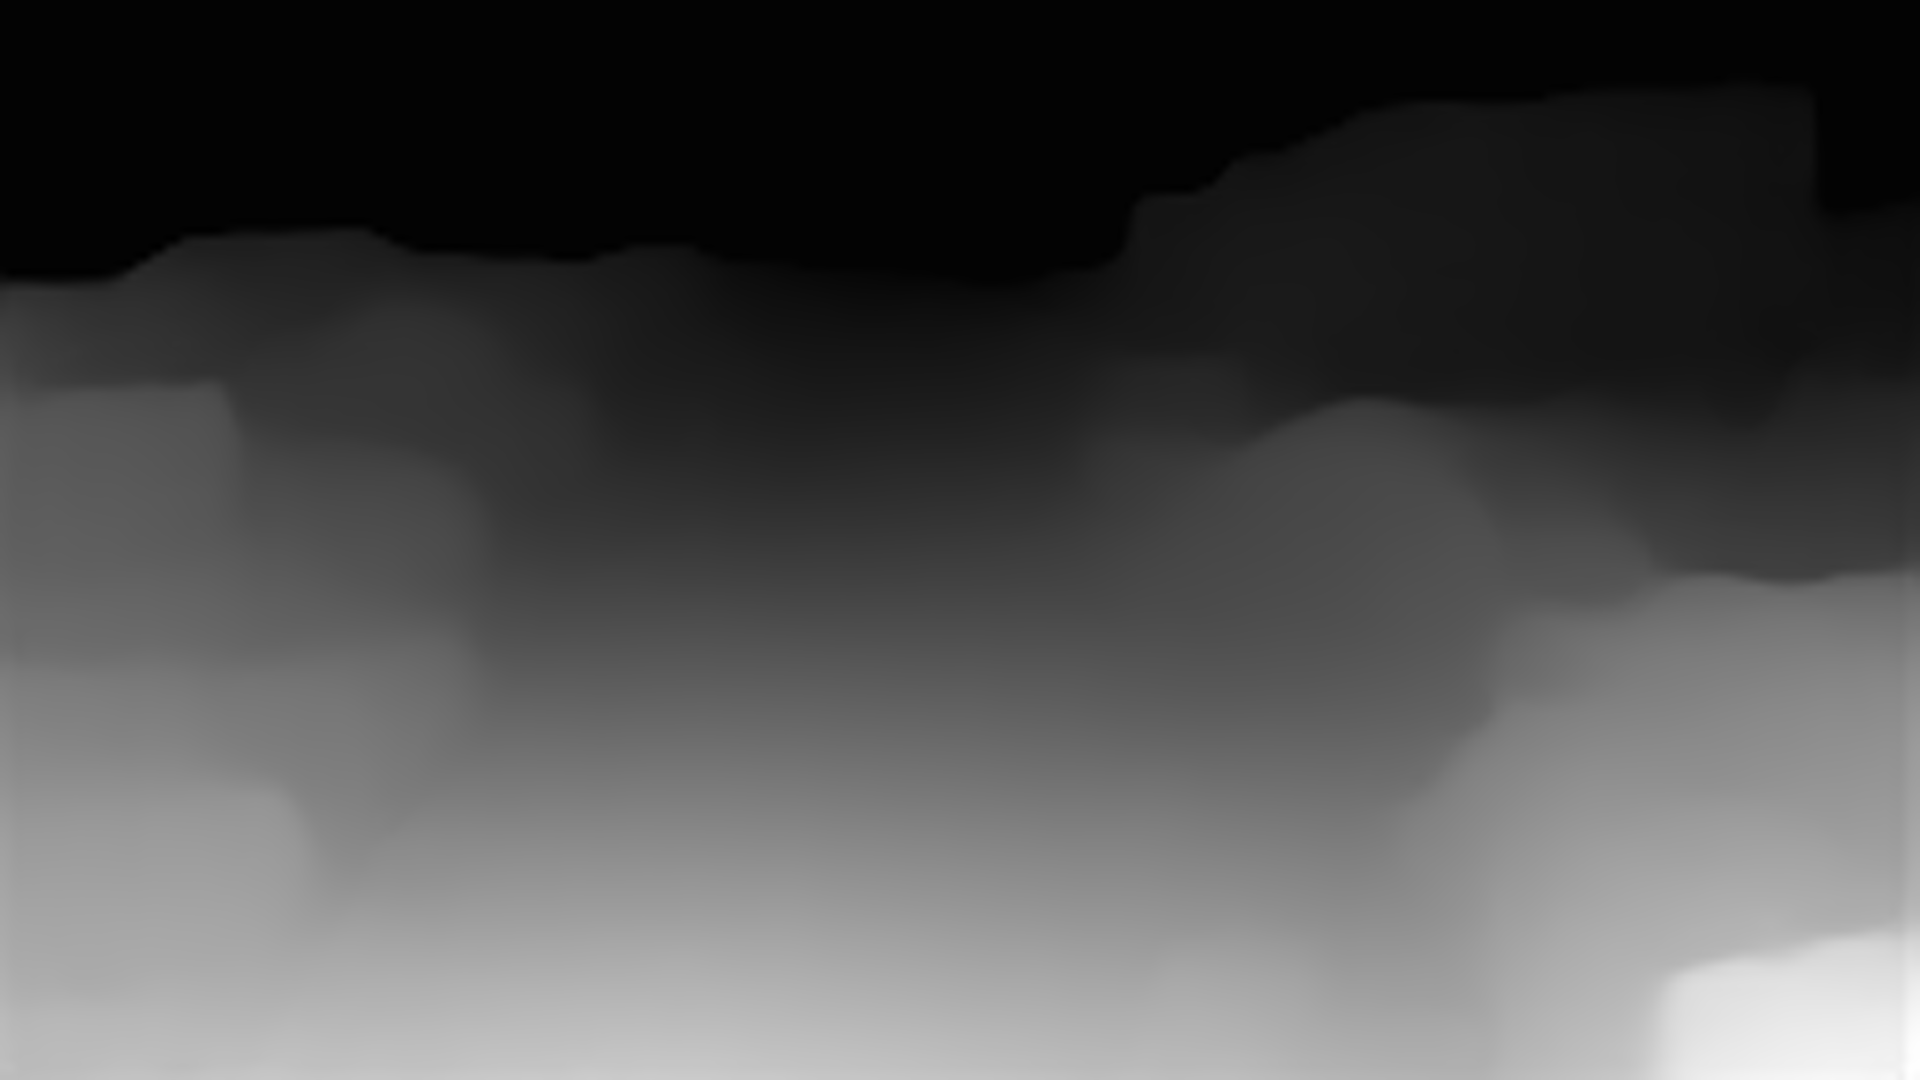

Depth map video saved as 'depth_grayscale.mp4'


In [5]:
import cv2
import torch
import numpy as np
from google.colab.patches import cv2_imshow

# Load MiDaS
midas = torch.hub.load("intel-isl/MiDaS", "MiDaS_small")
midas.eval()
transform = torch.hub.load("intel-isl/MiDaS", "transforms").small_transform

# Video path
video_path = "3696014-hd_1920_1080_24fps (1).mp4"  # Your video file name

# Open video
cap = cv2.VideoCapture(video_path)
if not cap.isOpened():
    print(f"Error: Could not open video file: {video_path}")
    exit()

# Get video properties
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = int(cap.get(cv2.CAP_PROP_FPS))

# Create video writer for grayscale output
out = cv2.VideoWriter('depth_grayscale.mp4',
                     cv2.VideoWriter_fourcc(*'mp4v'),
                     fps,
                     (frame_width, frame_height),
                     isColor=False)  # Set to False for grayscale

frame_count = 0
try:
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        frame_count += 1
        # Process every 2nd frame to speed up processing
        if frame_count % 2 != 0:
            continue

        # Convert BGR to RGB
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        # Transform frame for MiDaS
        input_batch = transform(frame_rgb)

        # Depth estimation
        with torch.no_grad():
            prediction = midas(input_batch)
            prediction = torch.nn.functional.interpolate(
                prediction.unsqueeze(1),
                size=(frame_height, frame_width),
                mode="bicubic",
                align_corners=False,
            ).squeeze()

        # Convert to grayscale depth map
        depth_map = prediction.cpu().numpy()
        depth_grayscale = np.uint8(255 * (depth_map - depth_map.min()) / (depth_map.max() - depth_map.min()))

        # Write frame
        out.write(depth_grayscale)

        # Display progress
        if frame_count % 30 == 0:
            print(f"Processed {frame_count} frames")
            # Display current frame
            cv2_imshow(depth_grayscale)
            from IPython.display import clear_output
            clear_output(wait=True)

except Exception as e:
    print(f"Error during processing: {str(e)}")

finally:
    # Cleanup
    cap.release()
    out.release()
    cv2.destroyAllWindows()
    print("Processing complete")

# Display a sample frame
cv2_imshow(depth_grayscale)
print("Depth map video saved as 'depth_grayscale.mp4'")